In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [2]:
data_path = "../data/combined_data.csv"

In [3]:
df = pd.read_csv(data_path)

In [4]:
df[['Speed Follower','Speed Leader']]

,Speed Follower,Speed Leader
0,55.310,55.130
1,55.170,55.255
2,55.030,55.380
3,55.040,55.430
4,55.050,55.480
...,...,...
741167,95.560,95.130
741168,95.450,95.125
741169,95.340,95.120
741170,95.375,95.055


In [5]:
def kmh_to_ms(column):
    return column * (5 / 18)

In [6]:
df['Speed Follower'] = kmh_to_ms(df['Speed Follower'])
df['Speed Leader'] = kmh_to_ms(df['Speed Leader'])

### Divide the dataset based on the gap setting

In [7]:
medium_gap_df = df[df['gap_setting']=='Medium']
short_gap_df = df[df['gap_setting']=='Short']
long_gap_df = df[df['gap_setting']=='Long']
xlong_gap_df = df[df['gap_setting']=='XLong']

In [8]:
medium_gap_df.shape,short_gap_df.shape,long_gap_df.shape,xlong_gap_df.shape

((181318, 12), (184718, 12), (181868, 12), (193268, 12))

In [9]:
medium_gap_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181318 entries, 181868 to 363185
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             181318 non-null  int64  
 1   Time                   181318 non-null  float64
 2   Speed Follower         181318 non-null  float64
 3   Speed Leader           181318 non-null  float64
 4   Smooth Speed Follower  181318 non-null  float64
 5   Smooth Speed Leader    181318 non-null  float64
 6   Spacing                181318 non-null  float64
 7   file_path              181318 non-null  object 
 8   gap_setting            181318 non-null  object 
 9   desired_speed          181318 non-null  int64  
 10  free_flow_speed        181318 non-null  int64  
 11  speed_fluctuation      181318 non-null  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 18.0+ MB


### Calibration

In [10]:
# initial_params = [30.0, 1.5, 2.0, 1.0, 1.5]


def modified_idm_model(params, time, lead_speed, initial_spacing, initial_speed):
    """
    Stable IDM model with checks for inf/nan and negative delta_v.
    """
    v0, T, s0, a_max, b = params
    spacing = [initial_spacing]
    speed = [initial_speed]
    eps = 1e-6  # Small constant to avoid division by zero

    for t in range(1, len(time)):
        dt = time[t] - time[t - 1]
        delta_v = lead_speed[t - 1] - speed[-1]

        # --- Compute s_star with constraints ---
        s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
        s_star = max(s_star, s0)  # Never allow s_star < s0 (minimum jam distance)

        # --- Handle negative delta_v (follower faster than leader) ---
        if delta_v < 0:
            # Reduce the impact of negative delta_v to prevent extreme braking
            s_star = s0 + speed[-1] * T  # Ignore the (negative) dynamic term

        # --- Stabilize acceleration calculation ---
        spacing_denominator = max(spacing[-1], eps)  # Avoid division by zero
        a = a_max * (1 - (speed[-1] / v0) ** 4 - (s_star / spacing_denominator) ** 2)

        # --- Limit acceleration to physical bounds ---
        a = np.clip(a, -b, a_max)  # Deceleration cannot exceed comfortable braking (b)

        # --- Update speed and spacing ---
        v_new = max(speed[-1] + a * dt, 0)  # Speed cannot be negative
        s_new = max(spacing[-1] + (lead_speed[t - 1] - speed[-1]) * dt, 0)  # Spacing cannot be negative

        spacing.append(s_new)
        speed.append(v_new)

    return np.array(spacing), np.array(speed)


# Define the IDM model
def idm_model(params, time, lead_speed, initial_spacing, initial_speed):
    v0, T, s0, a_max, b = params
    spacing = [initial_spacing]
    speed = [initial_speed]
    for t in range(1, len(time)):
        dt = time[t] - time[t-1]
        delta_v = lead_speed[t-1] - speed[-1]
        # Compute desired spacing
        s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
        # Compute acceleration with stability check
        a = a_max * (1 - (speed[-1] / v0)**4 - (s_star / spacing[-1])**2)
        # Update speed and spacing
        v_new = speed[-1] + a * dt
        s_new = spacing[-1] + (lead_speed[t-1] - speed[-1]) * dt
        
        spacing.append(s_new)
        speed.append(v_new)
    return np.array(spacing), np.array(speed)


# import numpy as np

# def idm_model(params, time, lead_speed, initial_spacing, initial_speed):
#     v0, T, s0, a_max, b = params
#     spacing = [initial_spacing]
#     speed = [initial_speed]
    
#     for t in range(1, len(time)):
#         dt = time[t] - time[t-1]
#         delta_v = lead_speed[t-1] - speed[-1]
        
#         # Compute desired spacing
#         s_star = s0 + speed[-1] * T + (speed[-1] * delta_v) / (2 * np.sqrt(a_max * b))
        
#         # Compute acceleration with stability check
#         a = a_max * (1 - (speed[-1] / v0)**2 - (s_star / (spacing[-1] + 1e-5))**2)
        
#         # Update speed and spacing
#         v_new = max(speed[-1] + a * dt, 0)  # Ensure speed is non-negative
#         s_new = max(spacing[-1] + (lead_speed[t-1] - speed[-1]) * dt + 0.5 * a * dt**2, s0)  # Ensure spacing is at least s0
        
#         spacing.append(s_new)
#         speed.append(v_new)
    
#     return np.array(spacing), np.array(speed)


In [11]:
# (time_subset, lead_speed_subset, experimental_spacing_subset, initial_spacing, initial_speed

In [12]:
# Define the objective function (spacing RMSE)
def objective(params, time, lead_speed, experimental_spacing, initial_spacing, initial_speed):
    # simulated_spacing, _ = idm_model(params, time, lead_speed, initial_spacing, initial_speed)
    simulated_spacing, _ = modified_idm_model(params, time, lead_speed, initial_spacing, initial_speed)
    rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing)**2))
    return rmse


In [28]:
def calibaration_start(df):
    # Split the data into six subsets (each 200 seconds long)
    subset_length = int(200 / 0.02)  # 200 seconds, assuming 0.02-second time steps
    num_subsets = 6
    subsets = [df.iloc[i * subset_length:(i + 1) * subset_length] for i in range(num_subsets)]

    print(f"Number of Subset: {len(subsets)}")
    # Calibrate on each subset
    best_rmse = np.inf
    best_params = None

    for i, subset in enumerate(subsets):
        print(f"-------------------Calibrating on subset {i + 1}-------------------")

        # Extract data for the subset
        time_subset = subset['Time'].values
        lead_speed_subset = subset['Speed Leader'].values
        follow_speed_subset = subset['Speed Follower'].values
        experimental_spacing_subset = subset['Spacing'].values

        # Initial conditions
        initial_spacing = experimental_spacing_subset[0]
        initial_speed = follow_speed_subset[0]

        # Initial guess for parameters
        #         initial_params = [0.5, 0.5, 2.0, 1.5]

        #         initial_params = [25, 1.0, 1.0, 1.0, 1.67]
        # initial_params = [v_0, time_headway, inital_sapcing, max_acc, comportable_braking_dec]
        initial_params = [14, 1.5, 2.0, 2.03, 2]

        # Bounds for parameters
        #         bounds = [(0, None), (0, None), (0, None), (0, None)]
        # Example bounds for IDM parameters [v0, T, s0, a_max, b]
        bounds = [
            (20.0, 40.0),  # v0: Desired speed (m/s)
            (0.5, 2.5),  # T: Safe time headway (s)
            (1.0, 5.0),  # s0: Minimum jam distance (m)
            (0.5, 2.0),  # a_max: Maximum acceleration (m/s²)
            (1.0, 2.0)  # b: Comfortable deceleration (m/s²)
        ]
        #         bounds = [(20.0, 30.0), (1.0, 3.0), (1.0, 5.0), (0.5, 2.0), (1.0, 2.0)]

        # Run optimization
        result = minimize(objective, initial_params, args=(
        time_subset, lead_speed_subset, experimental_spacing_subset, initial_spacing, initial_speed),
                          bounds=bounds, method='L-BFGS-B')

        # Simulate with the calibrated parameters
        # simulated_spacing, _ = idm_model(result.x, time_subset, lead_speed_subset, initial_spacing, initial_speed)
        simulated_spacing, _ = modified_idm_model(result.x, time_subset, lead_speed_subset, initial_spacing, initial_speed)

        print(f"Simulated Spacing: {len(simulated_spacing)}")
        print(f"Experimental Spacing: {len(experimental_spacing_subset)}")
        rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing_subset) ** 2))

        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = result.x

        print(f"Subset {i + 1} RMSE: {rmse:.4f}")
        print(f"Params: {result.x}")
    print("-------------------------------------------------")
    print(f"Best params: {best_params} \nBest RMSE : {best_rmse}")
    return best_params, best_rmse

def test_and_viz_full_dataset(df, best_params,model_name,report_path, limit=None):
    # Extract relevant columns
    time = np.arange(0, len(df) * 0.02, 0.02)  # Assuming time increments by 0.02 seconds
    #     time = df['Time'].values
    lead_speed = df['Speed Leader'].values
    follow_speed = df['Speed Follower'].values
    experimental_spacing = df['Spacing'].values  # Assuming this is the spacing

    # Test the best model on the entire dataset
    # simulated_spacing_full, simulated_speed_full = idm_model(best_params, time, lead_speed, experimental_spacing[0],
    #                                                          follow_speed[0])
    simulated_spacing_full, simulated_speed_full = modified_idm_model(best_params, time, lead_speed, experimental_spacing[0],
                                                             follow_speed[0])
    rmse_full = np.sqrt(np.mean((simulated_spacing_full - experimental_spacing) ** 2))
    print("-----------------------------------------------------------------------------")
    print(f"Full dataset RMSE: {rmse_full:.4f}")

    # Apply the limit to the data
    if limit is not None:
        start, end = limit
        mask = (time >= start) & (time <= end)
        time = time[mask]
        experimental_spacing = experimental_spacing[mask]
        simulated_spacing_full = simulated_spacing_full[mask]
        follow_speed = follow_speed[mask]
        simulated_speed_full = simulated_speed_full[mask]
        lead_speed = lead_speed[mask]

    # Visualize the results
    import matplotlib.pyplot as plt

    # Plot simulated vs experimental spacing
    plt.figure(figsize=(12, 6))
    plt.plot(time, experimental_spacing, label='Experimental Spacing', color='blue', linestyle='-', linewidth=0.5)
    plt.plot(time, simulated_spacing_full, label='IDM Simulated Spacing', color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Spacing (m)')
    plt.title(f'Simulated vs Experimental Spacing of {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_spacing.png")
    plt.show()

    # Plot simulated vs experimental speed (including leader speed)
    plt.figure(figsize=(12, 6))
    plt.plot(time, follow_speed, label='Experimental Follower Speed', color='blue', linestyle='-', linewidth=0.5)
    plt.plot(time, simulated_speed_full, label='IDM Simulated Follower Speed', color='black', linestyle='-', linewidth=0.5)
    plt.plot(time, lead_speed, label='Leader Speed', color='green', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Simulated vs Experimental Speed of {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_speed.png")
    plt.show()

In [29]:
medium_gap_best_params,medium_gap_best_rmse = calibaration_start(medium_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 68.8405
Params: [20.          1.93518219  1.          2.          2.        ]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 26.3007
Params: [22.11532303  1.28593523  1.73219938  2.          2.        ]
-------------------Calibrating on subset 3-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 90.6770
Params: [20.          2.04602645  1.          2.          2.        ]
-------------------Calibrating on subset 4-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: 36.1547
Params: [27.72117224  1.01038152  1.61823889  2.          1.99220966]
-------------------Calibrating on subset 5-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 52.1043
Params: [2

In [30]:
report_path = "../REPORTS/IDM/"
model_name = "IDM_medium_gap"

-----------------------------------------------------------------------------
Full dataset RMSE: 93.7915


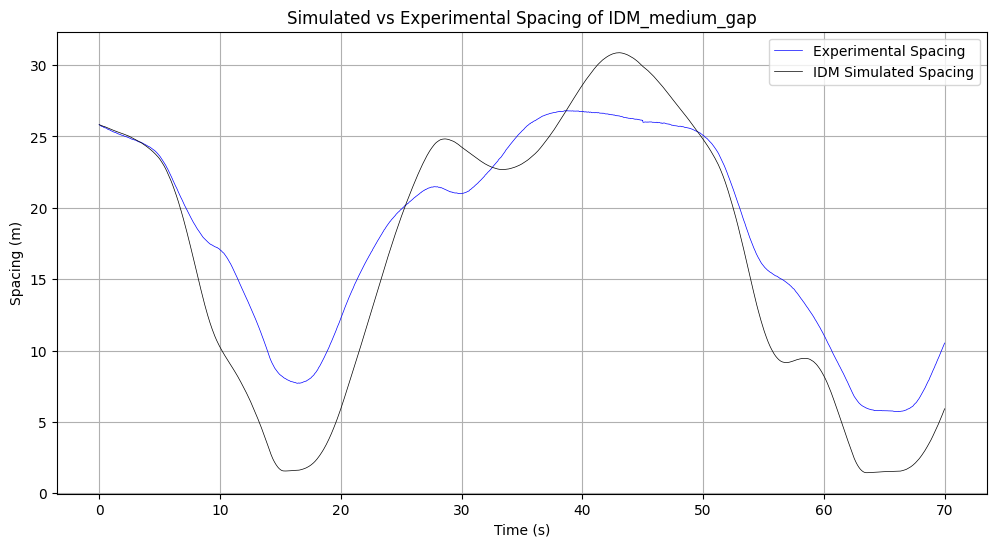

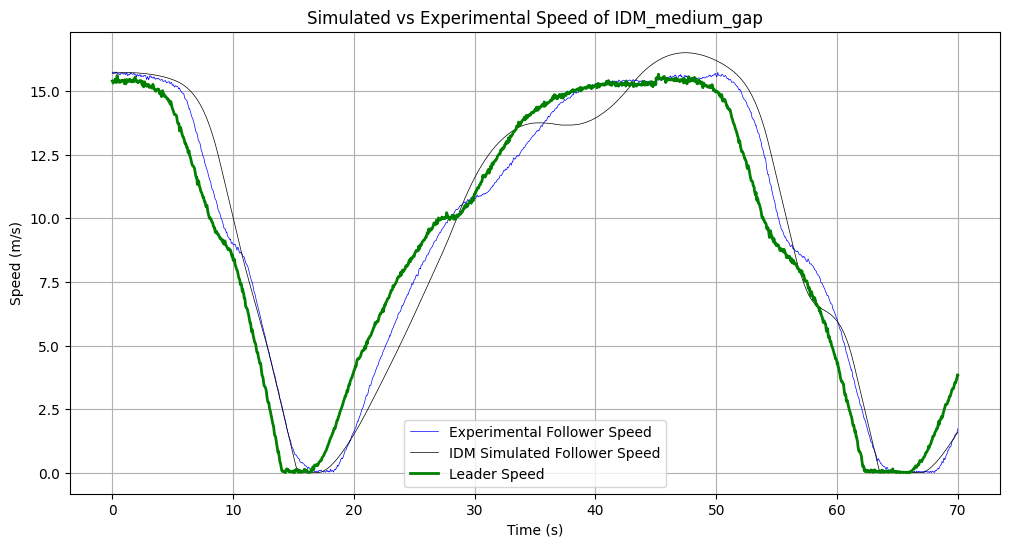

In [31]:
test_and_viz_full_dataset(medium_gap_df, medium_gap_best_params,model_name,report_path, limit=(0, 70))

In [32]:
short_gap_best_params,short_gap_best_rmse = calibaration_start(short_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 17.5593
Params: [20.28003695  0.54883805  1.02431103  1.86895422  1.99474373]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 23.8376
Params: [22.49439308  1.32491761  1.85454629  1.9999993   1.99999983]
-------------------Calibrating on subset 3-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 70.7713
Params: [20.          0.70895274  5.          2.          2.        ]
-------------------Calibrating on subset 4-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: 38.8627
Params: [40.   0.5  1.   2.   2. ]
-------------------Calibrating on subset 5-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 55.3835
Params: [26.03971735  2.12764705  1.         

-----------------------------------------------------------------------------
Full dataset RMSE: 164.1305


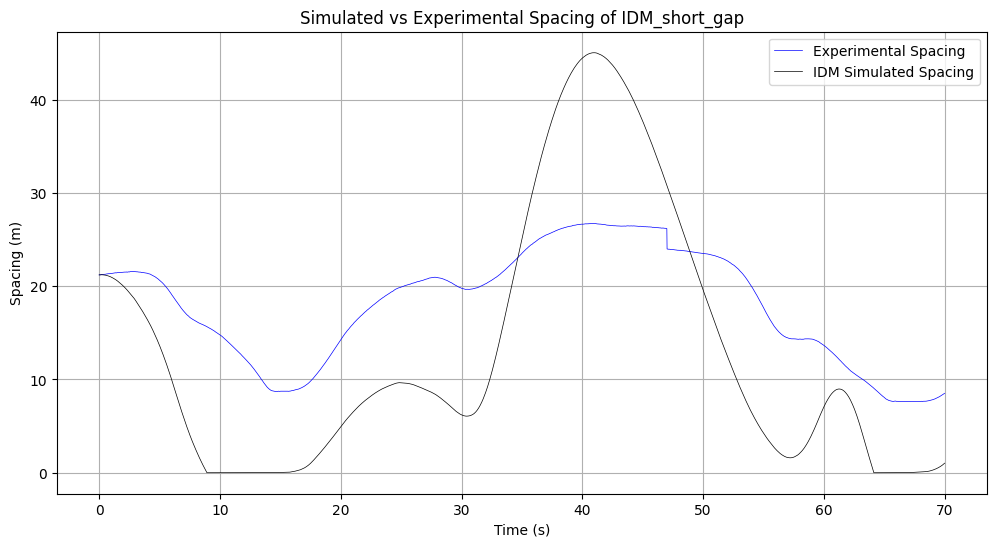

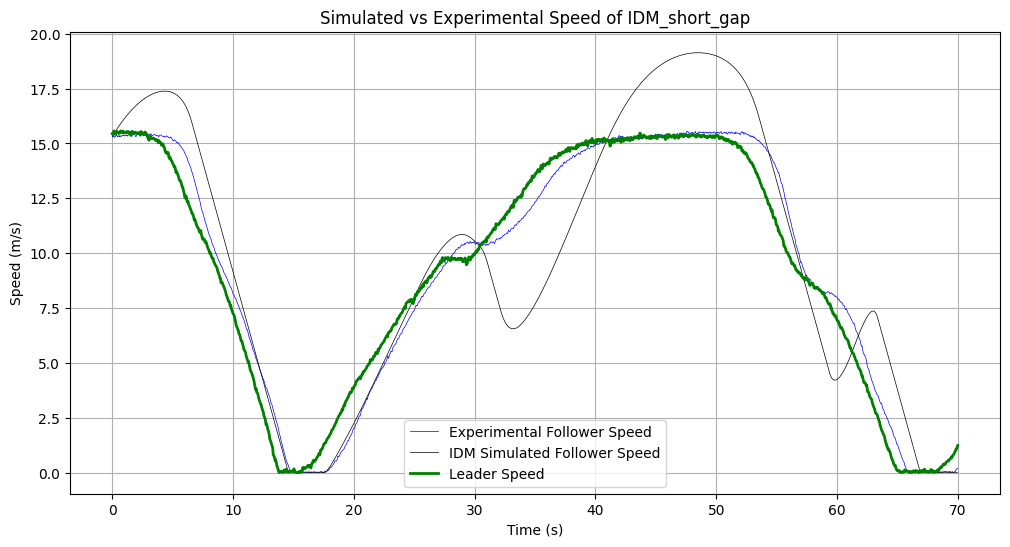

In [33]:
model_name = "IDM_short_gap"
test_and_viz_full_dataset(short_gap_df,short_gap_best_params,model_name,report_path,limit=(0, 70))

In [34]:
long_gap_best_params,long_gap_best_rmse = calibaration_start(long_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 9.5759
Params: [20.          1.29366241  3.81148494  2.          2.        ]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 33.8002
Params: [21.38262878  0.93975249  2.18063366  1.48388352  1.78578729]
-------------------Calibrating on subset 3-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 37.1502
Params: [20.02039062  0.5         3.73554555  2.          2.        ]
-------------------Calibrating on subset 4-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: 41.9990
Params: [24.98384323  0.78477371  1.          2.          2.        ]
-------------------Calibrating on subset 5-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 57.8947
Params: [24

-----------------------------------------------------------------------------
Full dataset RMSE: 207.8966


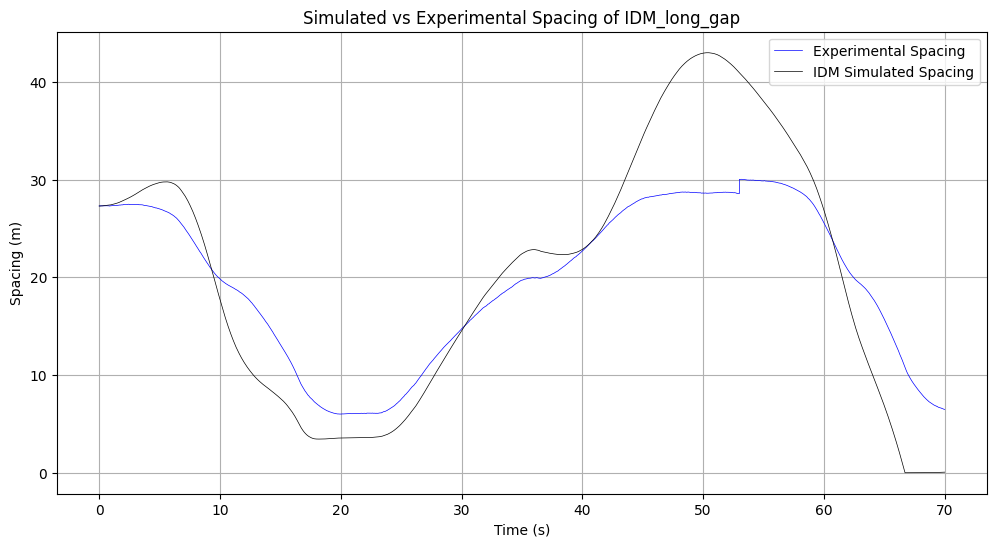

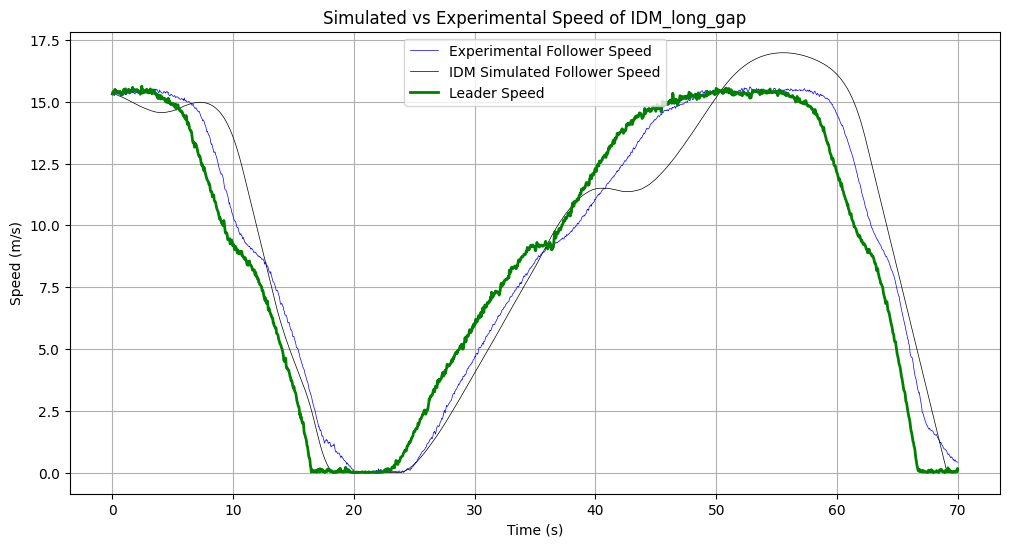

In [35]:
model_name = "IDM_long_gap"
test_and_viz_full_dataset(long_gap_df,long_gap_best_params,model_name,report_path,limit=(0, 70))

In [36]:
xlong_gap_best_params,xlong_gap_best_rms = calibaration_start(xlong_gap_df)

Number of Subset: 6
-------------------Calibrating on subset 1-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 1 RMSE: 11.2538
Params: [20.14665374  1.40996148  4.70820053  2.          1.11388335]
-------------------Calibrating on subset 2-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 2 RMSE: 26.6275
Params: [20.00290015  1.82031393  1.          2.          1.95961606]
-------------------Calibrating on subset 3-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 3 RMSE: 71.0265
Params: [20.2131514   1.67404719  1.          2.          2.        ]
-------------------Calibrating on subset 4-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 4 RMSE: 41.5153
Params: [25.49864256  1.58203073  1.76344081  2.          2.        ]
-------------------Calibrating on subset 5-------------------
Simulated Spacing: 10000
Experimental Spacing: 10000
Subset 5 RMSE: 34.6290
Params: [2

-----------------------------------------------------------------------------
Full dataset RMSE: 237.8052


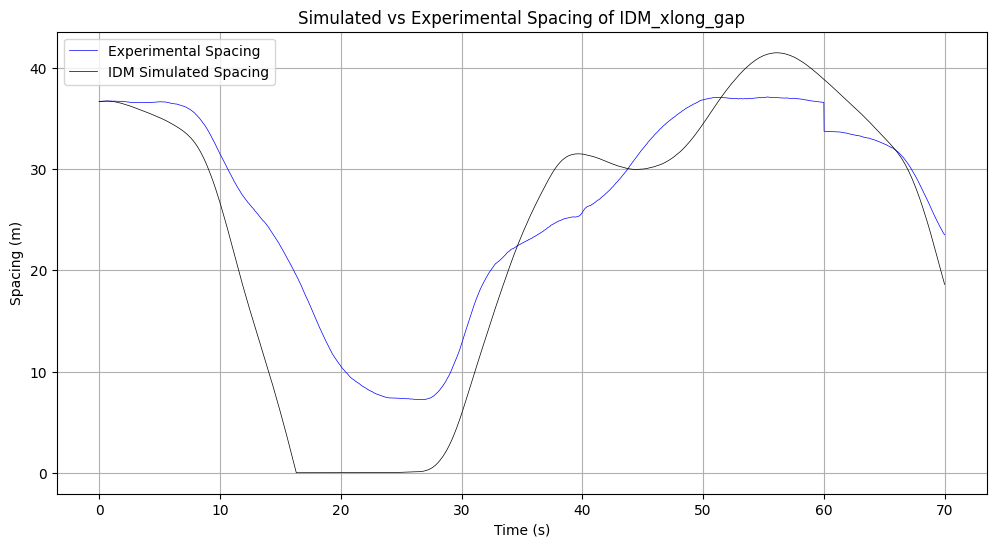

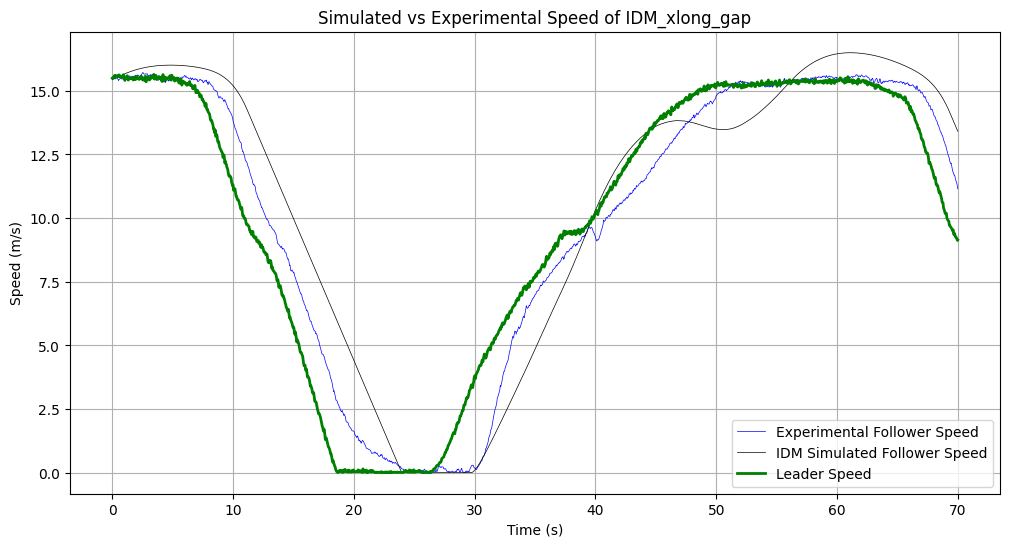

In [37]:
model_name = "IDM_xlong_gap"
test_and_viz_full_dataset(xlong_gap_df,xlong_gap_best_params,model_name,report_path,limit=(0, 70))